In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import digamma 
from scipy.linalg import sqrtm
from scipy.special import expit
import seaborn as sns

In [121]:
num_of_sample = 800

XX'를 계산해주는 함수 (파이썬에서 벡터 * 벡터는 항상 스칼라 값을 가짐)

In [122]:
def product(a):
    n = len(a)
    out = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            out[i,j] = a[i]*a[j]
    return(out)

Radial Basis로 변환하기 위해서 knot의 개수와 위치를 지정해주고 변환해주는 함수

In [123]:
def defineKnot(X,K=30):
    upper = max(X)
    lower = min(X)
    out = np.linspace(start=lower,stop=upper,num=K+2)[1:K+1]
    return(out)

In [124]:
def b(u,tau,sd):
    lst = []
    #lst.append(np.ones(len(u)))
    #lst.append(u)
    for i in tau:
        lst.append(abs((u-i)/sd)**3)
    out = np.array(lst)
    return(out)

Toy data를 만들기 위해서 함수를 지정해주고 정규분포 오차를 더해서 만들어주는 함수

In [125]:
def f1(x):
    #out = np.sin(2*np.pi*x)
    out = 3*np.exp(-30*(x-0.2)**2) + np.exp(-50*(x-0.7)**2)
    return(out)
def f2(x):
    out = np.sin(2*np.pi*x)
    #out = 3*np.exp(-30*(x-0.2)**2) + np.exp(-50*(x-0.7)**2)
    return(out)
def f3(x):
    #out = np.sin(2*np.pi*x)
    #out = 3*np.exp(-30*(x-0.2)**2) + np.exp(-50*(x-0.7)**2)
    out = x
    return(out)
def f4(x):
    #out = np.sin(2*np.pi*x)
    #out = 3*np.exp(-30*(x-0.2)**2) + np.exp(-50*(x-0.7)**2)
    out = 0*x
    return(out)

In [126]:
def mkToys(n=800,tau = 0.5):
    np.random.seed(4428)
    #non linear
    x1 = np.random.uniform(size = n)
    x2 = np.random.uniform(size = n)
    x3 = np.random.uniform(size = n)
    x4 = np.random.uniform(size = n)
    #linear
    z1 = np.random.uniform(size = n)
    z2 = np.random.uniform(size = n)
    z3 = np.random.uniform(size = n)
    z4 = np.random.uniform(size = n)
    e = np.random.normal(0,np.sqrt(0.5), size= n)
    y = f1(x1) + f2(x2) + f3(x3) + f4(x4)+ 0.6*z1 -1*z2 + e
    #out = np.column_stack([x,y])
    return(x1,x2,x3,x4,z1,z2,z3,z4,y)

# Make Toy Data and Basis

In [127]:
x1,x2,x3,x4,z1,z2,z3,z4,y = mkToys(num_of_sample)
y= y-y.mean()

In [128]:
sd1 = np.std(x1)
knot1 = defineKnot(x1)
d_x1 = b(x1,knot1,sd1).T

sd2 = np.std(x2)
knot2 = defineKnot(x2)
d_x2 = b(x2,knot2,sd2).T

sd3 = np.std(x3)
knot3 = defineKnot(x3)
d_x3 = b(x3,knot3,sd3).T

sd4 = np.std(x4)
knot4 = defineKnot(x4)
d_x4 = b(x4,knot4,sd4).T

# MFVB without variable selection

In [129]:
def mfvb(X,y,max_iter=100):
    
    N,p = X.shape
    a ,b, c, d = [10**(-7)]*4
    a_tilde = np.repeat(a + 0.5, p)
    b_tilde = np.repeat(b,p)
    c_tilde = c + (N+1)/2
    d_tilde = d
    
    mu_coeffs = np.repeat(0,p)
    sigma_coeffs = np.diag(np.repeat(1,p))
    
    for i in range(max_iter):
        expected_coeffs = mu_coeffs
        double_expected_coeffs = sigma_coeffs + product(mu_coeffs)
        diagonal_sigma = np.diag(sigma_coeffs)
        expected_alpha = np.array(list(map(lambda x : a_tilde[x]/b_tilde[x] , np.arange(0,p))))
        log_expected_alpha = np.array(list(map(lambda x : digamma(a_tilde[x])-np.log(b_tilde[x]) , np.arange(0,p))))
        expected_tau = c_tilde / d_tilde
        log_expected_tau = digamma(c_tilde)-np.log(d_tilde)
        sigma_coeffs = np.linalg.inv(np.diag(expected_alpha)+expected_tau*(X.T.dot(X)))
        mu_coeffs =  expected_tau*sigma_coeffs.dot(X.T.dot(y))
        b_tilde = np.array(list(map(lambda x : (diagonal_sigma[x]+mu_coeffs[x]**2)/2 + b , np.arange(0,p))))
        d_tilde = d+0.5*(y.T.dot(y)) - expected_coeffs.T.dot((X.T.dot(y)))+ 0.5*sum(np.diag(X.dot(double_expected_coeffs).dot(X.T)))
    return mu_coeffs,sigma_coeffs

In [130]:
def ci95s(m,c,y,x,d_x,n=1000):
    np.random.seed(4428)
    sampled_coef = np.random.multivariate_normal(m,c,size=n)
    y_grid = np.array([d_x.dot(b) for b in sampled_coef])
    quantile = np.array([np.sort(x)[[int(n*0.025),int(n*0.5),int(n*0.975)]] for x in y_grid.T])
    xq = np.array(sorted(np.array([x,quantile[:,0],quantile[:,1],quantile[:,2]]).T,key= lambda x : x[0]))
    plt.fill_between(xq[:,0], xq[:,1],xq[:,3], color =(0,0,0,0.2))
    plt.plot(xq[:,0],xq[:,2],'k',grid_x, y, '--')
    #plt.plot(x_grid,y_grid[10],'k',x_grid, f(x_grid), '--')
    plt.ylim(-2,2)
    #plt.show()

In [131]:
'''m1,c1 = mfvb(d_x1,y)
m2,c2 = mfvb(d_x2,y)
m3,c3 = mfvb(d_x3,y)
m4,c4 = mfvb(d_x4,y)'''

'm1,c1 = mfvb(d_x1,y)\nm2,c2 = mfvb(d_x2,y)\nm3,c3 = mfvb(d_x3,y)\nm4,c4 = mfvb(d_x4,y)'

In [132]:
'''grid_x = np.linspace(0,1,1000)
y1 = f1(grid_x)- f1(grid_x).mean()
y2 = f2(grid_x)- f2(grid_x).mean()
y3 = f3(grid_x)- f3(grid_x).mean()
y4 = f4(grid_x)- f4(grid_x).mean()

plt.figure(figsize=(10,5))


plt.subplot(221)
plt.title('f1')
ci95s(m1,c1,y1,x1,d_x1)

plt.subplot(222)
plt.title('f2')
ci95s(m2,c2,y2,x2,d_x2)

plt.subplot(223)
plt.title('f3')
ci95s(m3,c3,y3,x3,d_x3)

plt.subplot(224)
plt.title('f4')
ci95s(m4,c4,y4,x4,d_x4)


plt.show()'''

"grid_x = np.linspace(0,1,1000)\ny1 = f1(grid_x)- f1(grid_x).mean()\ny2 = f2(grid_x)- f2(grid_x).mean()\ny3 = f3(grid_x)- f3(grid_x).mean()\ny4 = f4(grid_x)- f4(grid_x).mean()\n\nplt.figure(figsize=(10,5))\n\n\nplt.subplot(221)\nplt.title('f1')\nci95s(m1,c1,y1,x1,d_x1)\n\nplt.subplot(222)\nplt.title('f2')\nci95s(m2,c2,y2,x2,d_x2)\n\nplt.subplot(223)\nplt.title('f3')\nci95s(m3,c3,y3,x3,d_x3)\n\nplt.subplot(224)\nplt.title('f4')\nci95s(m4,c4,y4,x4,d_x4)\n\n\nplt.show()"

# MFVB with variable selection

In [133]:
def cil95s(m,c,w,x,d_x,y,n=1000):
    np.random.seed(4428)
    #smaple_gam = np.random.r
    sampled_coef = np.random.multivariate_normal(m,c,size=n)
    lst = []
    for j in w:
        lst.append(np.random.binomial(1,j))
    w2ar = np.array(lst)
    
    y_grid = np.array([d_x.dot(np.diag(w2ar)).dot(b) for b in sampled_coef])
    #quantile = np.array([np.sort(x)[[int(n*0.05),int(n*0.5),int(n*0.95)]] for x in y_grid.T])
    quantile = np.array([np.sort(x)[[int(n*0.01),int(n*0.5),int(n*0.99)]] for x in y_grid.T])
    
    plt.ylim(-1.7,1.7)
    xq = np.array(sorted(np.array([x,quantile[:,0],quantile[:,1],quantile[:,2]]).T,key= lambda x : x[0]))
    plt.fill_between(xq[:,0], xq[:,1],xq[:,3], color =(0,0,0,0.2))
    #y = f(grid_x)- f(grid_x).mean()
    #plt.ylim(-1.5,1.5)
    plt.hlines(y=0,linestyles='dashed',colors='gray',xmin=0,xmax=1)
    plt.plot(xq[:,0],xq[:,2],'k',grid_x, y, '--')
    #plt.plot(x_grid,y_grid[10],'k',x_grid, f(x_grid), '--')
    plt.ylim(-2,2)
    #plt.show()

## plat prior $\rho$

In [134]:
def vselect_flat_rho(X,y,maxiter=100,rho = 0.5):
    N,p = X.shape
    sigmab = 1
    A = 10**(-7)
    B = 10**(-7)
    tau = 1
    w = np.repeat(0.5,p)
    lamb= np.log(rho/(1-rho))
    t = 0
    for iteration in range(maxiter):
        test= False
        W = np.diag(w)
        omega = product(w) + W.dot(np.eye(p)-W)
        sigma = np.linalg.inv(tau*np.multiply(X.T.dot(X),omega)+ (1/sigmab) * np.eye(p))
        mu = tau*sigma.dot(W.dot(X.T.dot(y)))

        s = B + 0.5*(np.linalg.norm(y)**2 -2*y.T.dot(X).dot(W).dot(mu) + np.trace(np.multiply(X.T.dot(X),omega).dot(product(mu) +sigma)))
        tau = (A+N/2)/s

        wstar = w.copy()
        eta = np.zeros(p)
        for j in range(p):
            eta[j] = lamb - 0.5*tau *(mu[j]**2 + sigma[j,j])*np.linalg.norm(X[:,j])**2 + tau *X[:,j].T.dot(y*mu[j]-np.delete(X, j, axis=1).dot(np.diag(np.delete(wstar,j))).dot(np.delete(mu,j,0)*mu[j] + np.delete(sigma,j,axis=1)[j,:]))
            wstar[j] = expit(eta[j]) 
        w = wstar
        #print(np.array(eta).round(2))
        #print(np.array(wstar).round(2))
    
    rmse = (y - X.dot(np.diag(w)).dot(mu)).dot(y - X.dot(np.diag(w)).dot(mu))
    return(mu,sigma,w,rmse)

In [138]:
%%time
lst = []
for j in np.linspace(0,1,101):
    ms1,cs1,ws1,like1 = vselect_flat_rho(d_x2,y,rho = j)
    lst.append([j,like1])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


Wall time: 1min 25s


In [139]:
df = pd.DataFrame(lst)
df.columns = ['rho', 'like']
df.like = 1-(df.like/(df.like[0]))

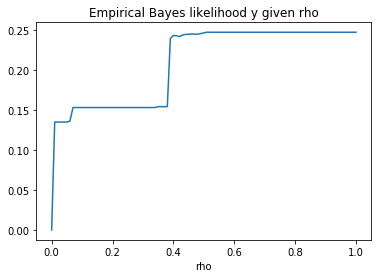

In [140]:
plt.title('Empirical Bayes likelihood y given rho')
plt.xlabel('rho')
plt.plot(df.rho,df.like)
plt.show()

In [16]:
plt'''ms1,cs1,ws1 = vselect_flat_rho(d_x1,y)
ms2,cs2,ws2 = vselect_flat_rho(d_x2,y)
ms3,cs3,ws3 = vselect_flat_rho(d_x3,y)
ms4,cs4,ws4 = vselect_flat_rho(d_x4,y)'''

'ms1,cs1,ws1 = vselect_flat_rho(d_x1,y)\nms2,cs2,ws2 = vselect_flat_rho(d_x2,y)\nms3,cs3,ws3 = vselect_flat_rho(d_x3,y)\nms4,cs4,ws4 = vselect_flat_rho(d_x4,y)'

In [17]:
'''grid_x = np.linspace(0,1,1000)
y1 = f1(grid_x)- f1(grid_x).mean()
y2 = f2(grid_x)- f2(grid_x).mean()
y3 = f3(grid_x)- f3(grid_x).mean()
y4 = f4(grid_x)- f4(grid_x).mean()

plt.figure(figsize=(10,5))


plt.subplot(221)
#plt.ylim(-1.4)
plt.title('f1')
cil95s(ms1,cs1,ws1,x1,d_x1,y1)

plt.subplot(222)
plt.title('f2')
cil95s(ms2,cs2,ws2,x2,d_x2,y2)

plt.subplot(223)
plt.title('f3')
cil95s(ms3,cs3,ws3,x3,d_x3,y3)

plt.subplot(224)
plt.title('f4')
cil95s(ms4,cs4,ws4,x4,d_x4,y4)


plt.show()'''

"grid_x = np.linspace(0,1,1000)\ny1 = f1(grid_x)- f1(grid_x).mean()\ny2 = f2(grid_x)- f2(grid_x).mean()\ny3 = f3(grid_x)- f3(grid_x).mean()\ny4 = f4(grid_x)- f4(grid_x).mean()\n\nplt.figure(figsize=(10,5))\n\n\nplt.subplot(221)\n#plt.ylim(-1.4)\nplt.title('f1')\ncil95s(ms1,cs1,ws1,x1,d_x1,y1)\n\nplt.subplot(222)\nplt.title('f2')\ncil95s(ms2,cs2,ws2,x2,d_x2,y2)\n\nplt.subplot(223)\nplt.title('f3')\ncil95s(ms3,cs3,ws3,x3,d_x3,y3)\n\nplt.subplot(224)\nplt.title('f4')\ncil95s(ms4,cs4,ws4,x4,d_x4,y4)\n\n\nplt.show()"

## beta prior $\rho$

In [112]:
def vselect_beta_rho(X,y,p_alpha,p_beta,maxiter=1000):#,rho = 0.46):
    #rho = 0.5
    beta_a , beta_b = p_alpha,p_beta
    beta_a_o , beta_b_o = p_alpha,p_beta
    N,p = X.shape
    sigmab = 1
    A = 10**(-7)
    B = 10**(-7)
    tau = 1
    w = np.repeat(0.5,p)
    #lamb= np.log(rho/(1-rho))
    t = 0
    for iteration in range(maxiter):
        lamb= digamma(beta_a) - digamma(beta_b)
        test= False
        W = np.diag(w)
        omega = product(w) + W.dot(np.eye(p)-W)
        sigma = np.linalg.inv(tau*np.multiply(X.T.dot(X),omega)+ (1/sigmab) * np.eye(p))
        mu = tau*sigma.dot(W.dot(X.T.dot(y)))

        s = B + 0.5*(np.linalg.norm(y)**2 -2*y.T.dot(X).dot(W).dot(mu) + np.trace(np.multiply(X.T.dot(X),omega).dot(product(mu) +sigma)))
        tau = (A+N/2)/s

        wstar = w.copy()
        eta = np.zeros(p)
        for j in range(p):
            eta[j] = digamma(beta_a)-digamma(beta_b) - 0.5*tau *(mu[j]**2 + sigma[j,j])*np.linalg.norm(X[:,j])**2 + tau *X[:,j].T.dot(y*mu[j]-np.delete(X, j, axis=1).dot(np.diag(np.delete(wstar,j))).dot(np.delete(mu,j,0)*mu[j] + np.delete(sigma,j,axis=1)[j,:]))
            wstar[j] = expit(eta[j]) 
        w = wstar
        beta_a = sum(w) + beta_a_o
        beta_b = p - sum(w) +beta_b_o
    #print(beta_a,beta_b)
    print(beta_a , beta_b)
    return(mu,sigma,w)

## comparison

In [113]:
grid_x = np.linspace(0,1,1000)
y1 = f1(grid_x)- f1(grid_x).mean()
y2 = f2(grid_x)- f2(grid_x).mean()
y3 = f3(grid_x)- f3(grid_x).mean()
y4 = f4(grid_x)- f4(grid_x).mean()

In [118]:
def plot(d_x1,x1,y1):

    p_alpha,p_beta = 1,1

    ms1,cs1,ws1 = vselect_beta_rho(d_x1,y,p_alpha=p_alpha,p_beta=p_beta)
    p_alpha,p_beta = 1,10
    ms2,cs2,ws2 = vselect_beta_rho(d_x1,y,p_alpha=p_alpha,p_beta=p_beta)
    p_alpha,p_beta = 10,1
    ms3,cs3,ws3 = vselect_beta_rho(d_x1,y,p_alpha=p_alpha,p_beta=p_beta)
    p_alpha,p_beta = 10,10
    ms4,cs4,ws4 = vselect_beta_rho(d_x1,y,p_alpha=p_alpha,p_beta=p_beta)

    plt.figure(figsize=(15,7))

    plt.subplot(2,4,1)
    plt.title('~Beta(1,1)')
    plt.bar(x =np.linspace(0,1,len(ws1)),height= ws1,width= 0.01,color='k')

    plt.subplot(2,4,2)
    plt.title('~Beta(1,10)')
    plt.bar(x =np.linspace(0,1,len(ws2)),height= ws2,width= 0.01,color='k')

    plt.subplot(2,4,3)
    plt.title('~Beta(10,1)')
    plt.bar(x =np.linspace(0,1,len(ws3)),height= ws3,width= 0.01,color='k')

    plt.subplot(2,4,4)
    plt.title('~Beta(10,10)')
    plt.bar(x =np.linspace(0,1,len(ws4)),height= ws4,width= 0.01,color='k')


    plt.subplot(2,4,5)
    #plt.title('f1')
    cil95s(ms1,cs1,ws1,x1,d_x1,y1)

    plt.subplot(2,4,6)
    #plt.title('f2')
    cil95s(ms2,cs2,ws2,x1,d_x1,y1)

    plt.subplot(2,4,7)
    #plt.title('f3')
    cil95s(ms3,cs3,ws3,x1,d_x1,y1)

    plt.subplot(2,4,8)
    #plt.title('f4')
    cil95s(ms4,cs4,ws4,x1,d_x1,y1)

    plt.show()

31.0 1.0
3.0 38.0
40.0 1.0
40.0 10.0


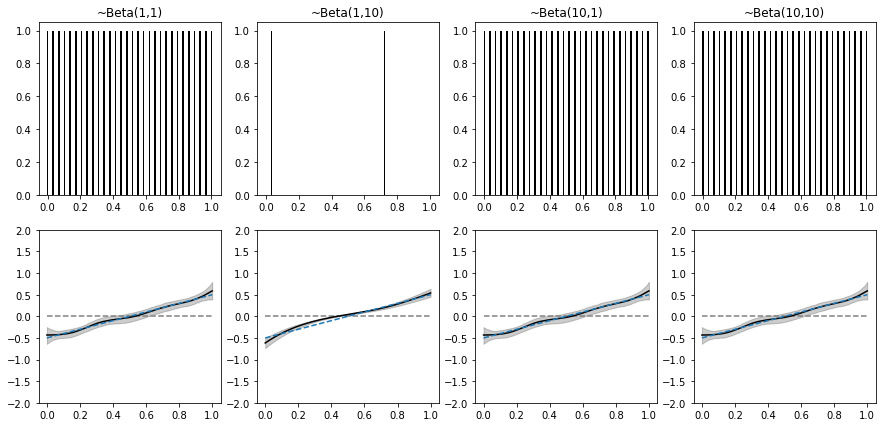

In [119]:
plot(d_x3,x3,y3)

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(2,4,1)
plt.title('~Beta(1,1)')
plt.bar(x =np.linspace(0,1,len(ws1)),height= ws1,width= 0.01,color='k')

plt.subplot(2,4,2)
plt.title('~Beta(1,10)')
plt.bar(x =np.linspace(0,1,len(ws2)),height= ws2,width= 0.01,color='k')

plt.subplot(2,4,3)
plt.title('~Beta(10,1)')
plt.bar(x =np.linspace(0,1,len(ws3)),height= ws3,width= 0.01,color='k')

plt.subplot(2,4,4)
plt.title('~Beta(10,10)')
plt.bar(x =np.linspace(0,1,len(ws4)),height= ws4,width= 0.01,color='k')


plt.subplot(2,4,5)
#plt.title('f1')
cil95s(ms1,cs1,ws1,x1,d_x1,y1)

plt.subplot(2,4,6)
#plt.title('f2')
cil95s(ms2,cs2,ws2,x1,d_x1,y1)

plt.subplot(2,4,7)
#plt.title('f3')
cil95s(ms3,cs3,ws3,x1,d_x1,y1)

plt.subplot(2,4,8)
#plt.title('f4')
cil95s(ms4,cs4,ws4,x1,d_x1,y1)

plt.show()

In [21]:
p_alpha,p_beta = 2,2

ms1,cs1,ws1 = vselect_beta_rho(d_x1,y,p_alpha=p_alpha,p_beta=p_beta)
ms2,cs2,ws2 = vselect_beta_rho(d_x2,y,p_alpha=p_alpha,p_beta=p_beta)
ms3,cs3,ws3 = vselect_beta_rho(d_x3,y,p_alpha=p_alpha,p_beta=p_beta)
ms4,cs4,ws4 = vselect_beta_rho(d_x4,y,p_alpha=p_alpha,p_beta=p_beta)

plt.figure(figsize=(15,7))

plt.subplot(2,4,1)
ddplt.bar(x =np.linspace(0,1,len(ws1)),height= ws1,width= 0.01,color='k')

plt.subplot(2,4,2)
plt.bar(x =np.linspace(0,1,len(ws2)),height= ws2,width= 0.01,color='k')

plt.subplot(2,4,3)
plt.bar(x =np.linspace(0,1,len(ws3)),height= ws3,width= 0.01,color='k')

plt.subplot(2,4,4)
plt.bar(x =np.linspace(0,1,len(ws4)),height= ws4,width= 0.01,color='k')


plt.subplot(2,4,5)
#plt.title('f1')
cil95s(ms1,cs1,ws1,x1,d_x1,y1)

plt.subplot(2,4,6)
#plt.title('f2')
cil95s(ms2,cs2,ws2,x2,d_x2,y2)

plt.subplot(2,4,7)
#plt.title('f3')
cil95s(ms3,cs3,ws3,x3,d_x3,y3)

plt.subplot(2,4,8)
#plt.title('f4')
cil95s(ms4,cs4,ws4,x4,d_x4,y4)



19.0 15.0
27.0 7.0
32.0 2.0
2.0 32.0


NameError: name 'ddplt' is not defined